# vanishing gradient modified

## multi layer network class

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt


class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成, sigmoidとreluのみ扱う
        activation_layer = {'sigmoid': layers.Sigmoid, 'relu': layers.Relu}
        self.layers = OrderedDict() # 追加した順番に格納
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = layers.SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, d):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        for idx in range(1, self.hidden_layer_num+2):
            grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grad


## vanishing sample
## sigmoid - gauss

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.13
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.09
                : 20. 正答率(テスト) = 0.0982
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1009
Generation: 40. 正答率(トレーニング) = 0.1
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.08
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.14
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.15
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.16
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.1
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.07
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.17
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.09
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.13
                : 130. 正答率(テスト) = 0.1135
Generatio

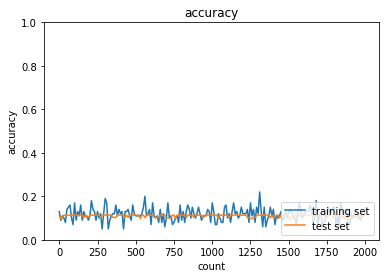

In [2]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## ReLU - gauss

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.15
                : 10. 正答率(テスト) = 0.101
Generation: 20. 正答率(トレーニング) = 0.08
                : 20. 正答率(テスト) = 0.101
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.16
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.12
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.14
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.12
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.11
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.07
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.1
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.09
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.17
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.08
                : 130. 正答率(テスト) = 0.1135
Generation

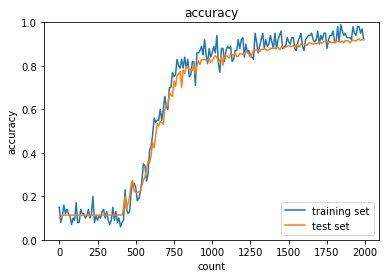

In [3]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## sigmoid - Xavier

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.17
                : 10. 正答率(テスト) = 0.1009
Generation: 20. 正答率(トレーニング) = 0.1
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.14
                : 30. 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.1
                : 40. 正答率(テスト) = 0.1046
Generation: 50. 正答率(トレーニング) = 0.13
                : 50. 正答率(テスト) = 0.1023
Generation: 60. 正答率(トレーニング) = 0.28
                : 60. 正答率(テスト) = 0.15
Generation: 70. 正答率(トレーニング) = 0.31
                : 70. 正答率(テスト) = 0.3155
Generation: 80. 正答率(トレーニング) = 0.18
                : 80. 正答率(テスト) = 0.1761
Generation: 90. 正答率(トレーニング) = 0.29
                : 90. 正答率(テスト) = 0.2325
Generation: 100. 正答率(トレーニング) = 0.24
                : 100. 正答率(テスト) = 0.2328
Generation: 110. 正答率(トレーニング) = 0.29
                : 110. 正答率(テスト) = 0.3079
Generation: 120. 正答率(トレーニング) = 0.12
                : 120. 正答率(テスト) = 0.1141
Generation: 130. 正答率(トレーニング) = 0.15
                : 130. 正答率(テスト) = 0.2294
Generation:

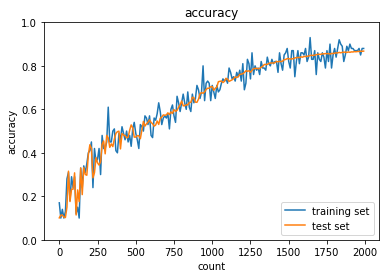

In [4]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## ReLU - He

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.48
                : 10. 正答率(テスト) = 0.4218
Generation: 20. 正答率(トレーニング) = 0.77
                : 20. 正答率(テスト) = 0.6925
Generation: 30. 正答率(トレーニング) = 0.6
                : 30. 正答率(テスト) = 0.7312
Generation: 40. 正答率(トレーニング) = 0.82
                : 40. 正答率(テスト) = 0.7717
Generation: 50. 正答率(トレーニング) = 0.84
                : 50. 正答率(テスト) = 0.7939
Generation: 60. 正答率(トレーニング) = 0.87
                : 60. 正答率(テスト) = 0.8275
Generation: 70. 正答率(トレーニング) = 0.87
                : 70. 正答率(テスト) = 0.7989
Generation: 80. 正答率(トレーニング) = 0.92
                : 80. 正答率(テスト) = 0.8615
Generation: 90. 正答率(トレーニング) = 0.85
                : 90. 正答率(テスト) = 0.8658
Generation: 100. 正答率(トレーニング) = 0.91
                : 100. 正答率(テスト) = 0.866
Generation: 110. 正答率(トレーニング) = 0.89
                : 110. 正答率(テスト) = 0.8815
Generation: 120. 正答率(トレーニング) = 0.9
                : 120. 正答率(テスト) = 0.8725
Generation: 130. 正答率(トレーニング) = 0.9
                : 130. 正答率(テスト) = 0.8847
Generation:

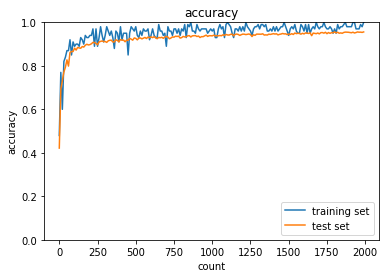

In [5]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] hidden_size_listの数字を変更してみよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.54
                : 10. 正答率(テスト) = 0.465
Generation: 20. 正答率(トレーニング) = 0.73
                : 20. 正答率(テスト) = 0.6326
Generation: 30. 正答率(トレーニング) = 0.76
                : 30. 正答率(テスト) = 0.716
Generation: 40. 正答率(トレーニング) = 0.77
                : 40. 正答率(テスト) = 0.7387
Generation: 50. 正答率(トレーニング) = 0.79
                : 50. 正答率(テスト) = 0.8005
Generation: 60. 正答率(トレーニング) = 0.87
                : 60. 正答率(テスト) = 0.8179
Generation: 70. 正答率(トレーニング) = 0.86
                : 70. 正答率(テスト) = 0.8343
Generation: 80. 正答率(トレーニング) = 0.9
                : 80. 正答率(テスト) = 0.8504
Generation: 90. 正答率(トレーニング) = 0.91
                : 90. 正答率(テスト) = 0.8666
Generation: 100. 正答率(トレーニング) = 0.92
                : 100. 正答率(テスト) = 0.8471
Generation: 110. 正答率(トレーニング) = 0.87
                : 110. 正答率(テスト) = 0.8747
Generation: 120. 正答率(トレーニング) = 0.94
                : 120. 正答率(テスト) = 0.886
Generation: 130. 正答率(トレーニング) = 0.88
                : 130. 正答率(テスト) = 0.8884
Generation:

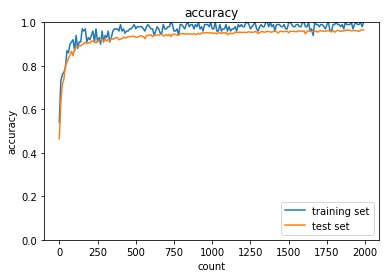

In [6]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# hidden_sizeを40->100に変更してみる
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

隠れ層のノード数を増やした。やや過学習気味になった？

## [try] sigmoid - He と relu - Xavier についても試してみよう
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## [try] sigmoid - He
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.12
                : 10. 正答率(テスト) = 0.1264
Generation: 20. 正答率(トレーニング) = 0.18
                : 20. 正答率(テスト) = 0.1911
Generation: 30. 正答率(トレーニング) = 0.14
                : 30. 正答率(テスト) = 0.1371
Generation: 40. 正答率(トレーニング) = 0.1
                : 40. 正答率(テスト) = 0.1428
Generation: 50. 正答率(トレーニング) = 0.37
                : 50. 正答率(テスト) = 0.2734
Generation: 60. 正答率(トレーニング) = 0.33
                : 60. 正答率(テスト) = 0.2688
Generation: 70. 正答率(トレーニング) = 0.35
                : 70. 正答率(テスト) = 0.3009
Generation: 80. 正答率(トレーニング) = 0.31
                : 80. 正答率(テスト) = 0.2777
Generation: 90. 正答率(トレーニング) = 0.19
                : 90. 正答率(テスト) = 0.2881
Generation: 100. 正答率(トレーニング) = 0.46
                : 100. 正答率(テスト) = 0.4403
Generation: 110. 正答率(トレーニング) = 0.39
                : 110. 正答率(テスト) = 0.3658
Generation: 120. 正答率(トレーニング) = 0.45
                : 120. 正答率(テスト) = 0.4492
Generation: 130. 正答率(トレーニング) = 0.4
                : 130. 正答率(テスト) = 0.3584
Generatio

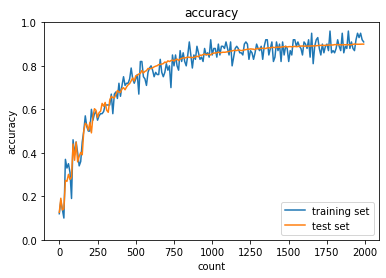

In [7]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

sigmoid-Heの組み合わせ  
ReLUの方が良さそう

## [try] relu - Xavier
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.04
                : 10. 正答率(テスト) = 0.0958
Generation: 20. 正答率(トレーニング) = 0.22
                : 20. 正答率(テスト) = 0.1386
Generation: 30. 正答率(トレーニング) = 0.17
                : 30. 正答率(テスト) = 0.098
Generation: 40. 正答率(トレーニング) = 0.23
                : 40. 正答率(テスト) = 0.1441
Generation: 50. 正答率(トレーニング) = 0.18
                : 50. 正答率(テスト) = 0.1547
Generation: 60. 正答率(トレーニング) = 0.25
                : 60. 正答率(テスト) = 0.2737
Generation: 70. 正答率(トレーニング) = 0.21
                : 70. 正答率(テスト) = 0.2058
Generation: 80. 正答率(トレーニング) = 0.15
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.23
                : 90. 正答率(テスト) = 0.2037
Generation: 100. 正答率(トレーニング) = 0.27
                : 100. 正答率(テスト) = 0.2987
Generation: 110. 正答率(トレーニング) = 0.33
                : 110. 正答率(テスト) = 0.2731
Generation: 120. 正答率(トレーニング) = 0.18
                : 120. 正答率(テスト) = 0.1965
Generation: 130. 正答率(トレーニング) = 0.26
                : 130. 正答率(テスト) = 0.2841
Generati

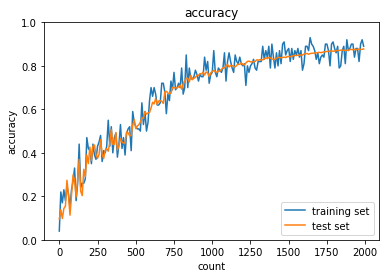

In [8]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

ReLU - Xavierの組み合わせ  
講義でもあったとおりXavierはsigmoidとの組み合わせの方がよさそう  
ReLUを使うならHe初期化